No. of Harris Interest points in Image 1:  246


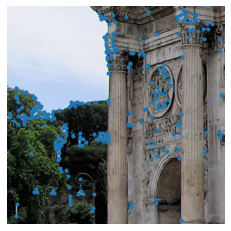

No. of Harris Interest points in Image 2:  246


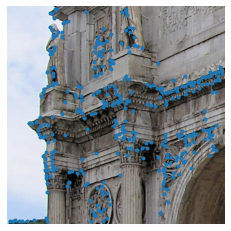

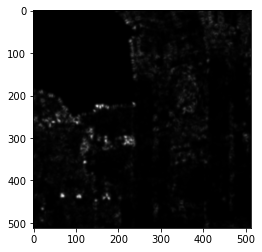

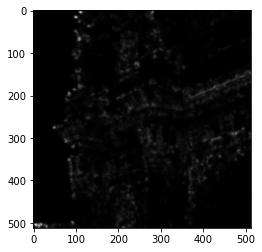

[259, 334, 382, 172, 16, 52, 133, 205, 214, 243, 152, 255, 348, 37, 0, 310, 0, 183, 298, 58, 104, 65, 109, 133, 198, 114, 75, 0, 370, 0]
estimate: [-5.08316183e-05 -2.95458157e-03  9.99995634e-01]
# inliers: 10
[104, 382, 0, 112, 300, 83, 356, 0, 82, 218, 0, 41, 233, 160, 98, 71, 285, 32, 298, 79, 278, 338, 92, 32, 338, 253, 234, 287, 72, 188]
estimate: [-0.00252586 -0.00193012  0.99999495]
# inliers: 1
[123, 146, 0, 86, 65, 112, 220, 16, 293, 338, 280, 155, 201, 361, 365, 49, 137, 295, 151, 360, 75, 280, 156, 375, 334, 175, 117, 65, 92, 0]
estimate: [-0.00523812 -0.00243627  0.99998331]
# inliers: 0
[167, 86, 316, 69, 133, 356, 279, 120, 0, 296, 287, 187, 40, 65, 32, 340, 14, 248, 32, 338, 0, 92, 375, 56, 114, 69, 251, 132, 208, 114]
estimate: [-0.00532352 -0.0012902   0.999985  ]
# inliers: 8
[243, 0, 338, 360, 122, 297, 220, 15, 211, 391, 23, 360, 19, 77, 381, 0, 340, 15, 234, 9, 160, 251, 165, 330, 109, 296, 0, 0, 266, 75]
estimate: [-0.00411519  0.          0.99999153]
# inliers: 

<ipython-input-3-8cf4cf458e31>:260: RuntimeWarning: invalid value encountered in double_scalars
  plt.plot([0, 10], [-c/b, -(c+10*a)/b], color=(0, 1, 0))
<ipython-input-3-8cf4cf458e31>:260: RuntimeWarning: divide by zero encountered in double_scalars
  plt.plot([0, 10], [-c/b, -(c+10*a)/b], color=(0, 1, 0))


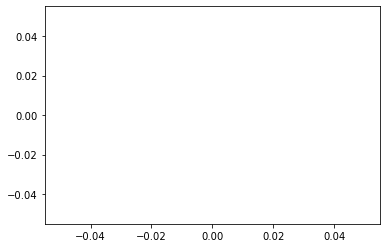

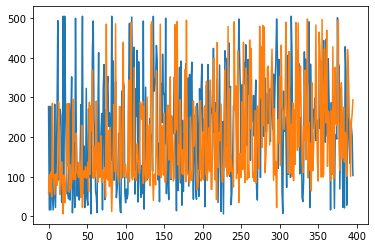

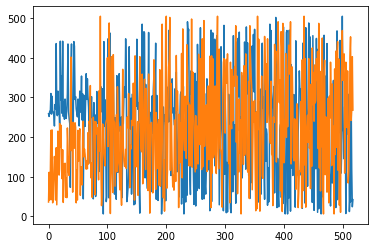

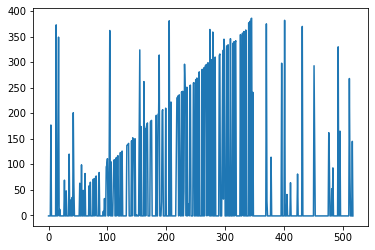

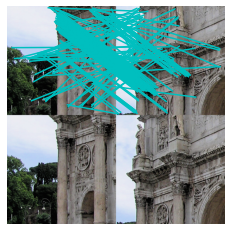

In [3]:
'''

Student Name:   Ciaran Carroll
Student Id:     13113259

Project 2:
Research and Implement Harris Corner Detection using Python/Numpy Investigating
the behaviour of the algorithm.

Overall Project Steps:
(1) - Find and plot Harris interest points by thresholding Harris response images
      for Image 1 and Image 2.
(2) - Form normalised patch descriptor vectors for all the Hips in image 1 and
      all the Hips in image 2.
(3) - Match these using inner product op & threshold for strong matches. Sort
      by match strength (strongest first). Result is a list of points
      correspondences.
(4) - 'Exhaustive RANSAC' to filter outliers from these and return best
      translation between the image (dr, dc).
(5) - Use the translation to make a composite image & return this.

'''

from pylab import *
import numpy as np
import random
from scipy.ndimage import filters
from matplotlib import pylab as plt
from PIL import Image

def compute_harris_response(image, sigma = 2):
    ''' Compute the Harris corner detector algorithm for each pixel
    in a gray level image. '''
    
    # Derivatives
    imagex = np.zeros(image.shape)
    filters.gaussian_filter(image, (sigma,sigma), (0,1), imagex)
    imagey = np.zeros(image.shape)
    filters.gaussian_filter(image, (sigma,sigma), (1,0), imagey)
    
    # Compute components of the Harris matrix
    A = filters.gaussian_filter(imagex*imagex, sigma)
    B = filters.gaussian_filter(imagex*imagey, sigma)
    C = filters.gaussian_filter(imagey*imagey, sigma)
    
    # Determinant and trace
    Det_M = A*C - B**2
    Tr_M = A + C

    Harris = Det_M / (Tr_M * (10**(-6)))
    
    return Harris
   
    
def get_harris_points(harris_im, min_d =10, threshold=0.1):   
    ''' Returns corners from a Harris response image. min_d is the minimum number of 
    pixels seperating corners and image boundary. '''
    
    # Find top corne candidates above a threshold
    corner_threshold = harris_im.max() * threshold
    harrisim_t = (harris_im > corner_threshold) * 1
    
    # Find coordinates of these candidates, and their responsevalues
    coords = array(harrisim_t.nonzero()).T
    candidate_values = [harris_im[c[0],c[1]] for c in coords]
    
    # Find the indices into the 'candidate_values' array that sort in order
    # of increasing response strength
    indices = argsort(candidate_values)[::-1]
    
    # store allowed point locations in array that sort
    allowed_locations = zeros(harris_im.shape)
    allowed_locations[min_d:-min_d,min_d:-min_d] = 1
    
    # select the best points using min_distance
    filtered_coords = []
    for i in indices:
        if allowed_locations[coords[i,0], coords[i,1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i,0]-min_d):(coords[i,0]+min_d),
                        (coords[i,1]-min_d):(coords[i,1]+min_d)] = 0
    
    return filtered_coords
    
    
def plot_harris_points(image,filtered_coords):
    ''' Plots corners found in image '''
    plt.figure()
    plt.gray()
    plt.imshow(image)
    plt.plot([p[1] for p in filtered_coords],
                [p[0] for p in filtered_coords],'.')
    plt.axis('off')
    plt.show()
    

def get_descriptors(image,filtered_coords,wid=5): #return pixel value
    ''' For each point return pixels values around the point using neighbourhood
    of width 2_wid+1 '''
    
    desc = []
    for coords in filtered_coords:
        patch = image[coords[0]-wid:coords[0]+wid+1,
                            coords[1]-wid:coords[1]+wid+1].flatten()
        desc.append(patch)
    return desc


def match(desc1, desc2, threshold=0.5): 
    ''' For each of the corner descriptor in image 1, select its match
    to the image 2 using normaliazed cross correlation. '''

    n = len(desc1[0])
    
    # pair-wise distances
    d = -np.ones((len(desc1),len(desc2)))
    for i in range(len(desc1)):
        for j in range(len(desc2)):
            d1 = (desc1[i] - np.mean(desc1[i])) / np.std(desc1[i])
            #print('length of d1 = ')
            #print(len(d1))
            d2 = (desc2[j] - np.mean(desc2[j])) / np.std(desc2[j])
            #print('length of d2 = ')
            #print(len(d2))
            
            ncc_value = np.sum(d1 * d2) / (n-1)
            if ncc_value > threshold:
                d[i,j] = ncc_value
            
    ndx = np.argsort(-d)
    matchscores = ndx[:,0]
    
    return matchscores


def match_twosided(desc1, desc2, threshold=0.5): #Same as above, two sided symmetric version
    ''' Two-sided symmetric version of match(). '''
    matches_12 = match(desc1,desc2,threshold)
    matches_21 = match(desc2,desc1,threshold)
    
    ndx_12 = np.where(matches_12 >= 0)[0]
    
    # Remove matches that are not symmetric
    for n in ndx_12:
        if matches_21[matches_12[n]] != n:
            matches_12[n] = -1
    
    return matches_12


def appendimages(image1, image2):
    ''' Return a new image that appends the two images side-by-side. '''
    
    # Select the image with the fewest rows and fill in enough empty rows
    rows1 = image1.shape[0]
    rows2 = image2.shape[0]
    
    if rows1 < rows2:
        im1 = np.concatenate((image1, np.zeros((rows2-rows1,image1.shape[1]))), axis=0)
    elif rows1 > rows2:
        im2 = np.concatenate((image2, np.zeros((rows1-rows2,image2.shape[1]))), axis=0)
    # If none of these cases are true, no filling needed    
    
    
    return np.concatenate((image1, image2), axis=1)

def augment(xys):
	axy = np.ones((len(xys), 3))
	axy[:, :2] = xys
	return axy

def estimate(xys):
	axy = augment(xys[:2])
	return np.linalg.svd(axy)[-1][-1, :]

def is_inlier(coeffs, xy, threshold):
	return np.abs(coeffs.dot(augment([xy]).T)) < threshold

def run_ransac(data, estimate, is_inlier, sample_size, goal_inliers, max_iterations, stop_at_goal=True, random_seed=None):
	best_ic = 0
	best_model = None
	random.seed(random_seed)
	for i in range(max_iterations):
		s = random.sample(list(data), int(sample_size))
		m = estimate(s)
		ic = 0
		for j in range(len(data)):
			if is_inlier(m, data[j]):
				ic += 1

		print (s)
		print ('estimate:', m,)
		print ('# inliers:', ic)

		if ic > best_ic:
			best_ic = ic
			best_model = m
			if ic > goal_inliers and stop_at_goal:
				break
	print ('took iterations:', i+1, 'best model:', best_model, 'explains:', best_ic)
	return best_model, best_ic
    
def plot_matches(image1, image2, locations1, locations2, matchscores, show_below=True):
    ''' Show a figure with lines joining the accepted matches '''
    image3 = appendimages(image1, image2)
    if show_below:
        image3 = np.vstack((image3, image3))
    
    plt.imshow(image3)
    
    cols1 = image1.shape[1]
    for i,m in enumerate(matchscores):
        if m>0:
            plt.plot([locations1[i][1],locations2[m][1]+cols1],[locations1[i][0],locations2[m][0]],'c')
    plt.axis('off')

image1_gray = np.array(Image.open('arch1.png').convert('L'))
image1_rgb = np.array(Image.open('arch1.png'))

image2_gray = np.array(Image.open('arch2.png').convert('L'))
image2_rgb = np.array(Image.open('arch2.png'))

n = 100
max_iterations = 100
goal_inliers = n * 0.3

harris_image1 = compute_harris_response(image1_gray)
filtered_coords1 = get_harris_points(harris_image1, 6)
print('No. of Harris Interest points in Image 1: ', len(filtered_coords1))
plot_harris_points(image1_rgb, filtered_coords1)

harris_image2 = compute_harris_response(image2_gray)
filtered_coords2 = get_harris_points(harris_image2, 6)
print('No. of Harris Interest points in Image 2: ', len(filtered_coords1))
plot_harris_points(image2_rgb, filtered_coords2)

plt.imshow(harris_image1)
plt.show()
plt.imshow(harris_image2)
plt.show()
    
wid = 5
harris_image3 = compute_harris_response(image1_gray, 5)
filtered_coords3 = get_harris_points(harris_image3, wid+1)
d1 = get_descriptors(image1_gray, filtered_coords3, wid)

#print(len(filtered_coords3))

harris_image4 = compute_harris_response(image2_gray, 5)
filtered_coords4 = get_harris_points(harris_image4 ,wid+1)
d2 = get_descriptors(image2_gray, filtered_coords4,wid)

#print(len(filtered_coords4))

matches = match_twosided(d1,d2)
scores = match(d1,d2)

m, b = run_ransac(scores, estimate, lambda x, y: is_inlier(x, y, 0.01), goal_inliers, max_iterations, 20)
a, b, c = m
plt.plot([0, 10], [-c/b, -(c+10*a)/b], color=(0, 1, 0))
plt.show()
plt.plot(filtered_coords4)
plt.show()
plt.plot(filtered_coords3)
plt.show()
plt.plot(matches)
plt.show()
plt.figure()
plt.gray()
plot_matches(image1_rgb, image2_rgb, filtered_coords3, filtered_coords4,matches)
plt.show()

